In [ ]:
#Function allowed to performe a sentiment text blob analysis using blobber

In [1]:
import json
import os 
import pandas as pd
import Json_to_df_1

#Lecture des json 
df_all = pd.DataFrame() 
Dossier_tweet = [x for x in os.listdir("sure")]
for file_json in Dossier_tweet:
    tweets = []
    file = "sure/" + file_json 
    nom_requete = file_json [:-30]
    with open(file, 'r') as f:
        for line in f.readlines():
            tweets.append(json.loads(line))
    df = Json_to_df_1.tweet_df(tweets) 
    df = df[['id_str','created_at','full_text','in_reply_to_status_id_str','retweet_count']]
    df['name_request'] = nom_requete
    df['begin_by_RT'] = df.full_text.map(lambda x: 1 if x.startswith('RT ') == True else 0)
    df['Tweet_natif_bq'] = df.full_text.map(lambda x: 1 if x.startswith('RT ' + nom_requete) == True else 0)
    frames = [df_all, df]
    df_all = pd.concat(frames)  
    
df_all = df_all.drop_duplicates(subset=['created_at','full_text','name_request'])

In [5]:
import re
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

def clean_tweet(tweet):
        '''
        Cleans tweet text by removing links,
        special characters - using regex statements.
        '''
        # In case you forget: you removed the (@[A-Za-z0-9]+)| reg ex.
        # useful site: http://regexr.com/
        if not tweet.endswith((u"à", u"è", u"é", u"ê", u"ï", u"û", u"ç")):
                    tweet = tweet.replace(u"à", "a")
                    tweet = tweet.replace(u"é", "e")
                    tweet = tweet.replace(u"è", "e")
                    tweet = tweet.replace(u"ê", "e")
                    tweet = tweet.replace(u"ï", "i")
                    tweet = tweet.replace(u"î", "i")
                    tweet = tweet.replace(u"ç", "c")
                    
        tweet = re.sub(r'(\s)@\w+',r'\1',tweet)
        tweet = re.sub(r'(\s)#\w+',r'\1',tweet)
                    
        return ' '.join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def get_tweet_sentiment(tweet): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
    
    # create TextBlob object of passed tweet text 
    analysis = tb(clean_tweet(tweet)) 
    
    # set sentiment from pattern analyzer
    if (analysis.sentiment[0] > 0.1 and analysis.sentiment[1] < 0.5): 
        return 'positive'
    elif (analysis.sentiment[0] < -0.1 and analysis.sentiment[1] < 0.5): 
        return 'negative'
    else: 
        return 'neutral'
    
def get_result(tweet): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
    
    # create TextBlob object of passed tweet text 
    analysis = tb(clean_tweet(tweet)) 

    return analysis.sentiment

In [6]:
df_all['sentiment'] = df_all.apply(lambda row: get_tweet_sentiment(row['full_text']), axis=1)
df_all['score'] = df_all.apply(lambda row: get_result(row['full_text']), axis=1)

In [8]:
df_natif = df_all.loc[df_all['begin_by_RT']==0]
df_g = pd.crosstab(df_natif['name_request'], df_natif['sentiment'], values=None, rownames=None, colnames=None, aggfunc=None, margins=True, dropna=True, normalize='index')
df_g['ratio_fp'] = df_g['negative'] / df_g['positive'] * 100
df_g.sort_values('ratio_fp', ascending = False )

sentiment,negative,neutral,positive,ratio_fp
name_request,,,,
@Boursorama,0.060344,0.625379,0.314277,19.200735
@SG_etvous,0.048265,0.666215,0.285521,16.904084
All,0.049462,0.617956,0.332583,14.872003
@SocieteGenerale,0.043692,0.598621,0.357686,12.215269
@SG_presse,0.044643,0.580357,0.375000,11.904762
@creditdunord,0.029703,0.587459,0.382838,7.758621


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from IPython.display import Image as im
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline 

In [22]:
def wc_app(name,sence):    
    tweet_cleaned = []

    df_natif = df_all.loc[df_all['begin_by_RT']==0]
    negative_df = df_natif.loc[df_natif['sentiment']==sence,['full_text','name_request']]
    negative_df = negative_df.loc[negative_df['name_request']==name,['full_text']]

    for tweet in negative_df['full_text']:
        tweet_cleaned.append(clean_tweet(tweet))

    raw_string = ' '.join(tweet_cleaned)

    words = raw_string.split(" ")
    words = [w for w in words if len(w) > 5]
    words = [w.lower() for w in words]
    words = [w for w in words if w not in STOPWORDS]
    
    wc = WordCloud(background_color="white", mode="RGBA", max_words=100)
    clean_string = ','.join(words)
    wc.generate(clean_string)
    plt.figure(figsize=[10,10])
    plt.imshow(wc)
    plt.axis("off")

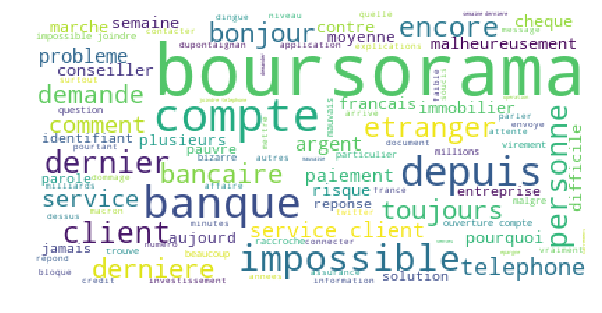

In [23]:
wc_app(name = "@Boursorama", sence = "negative")